# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/Zinser_SizeDist_regrid-30-15.nc'

data_seaflow = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_seaflow[var] = nc.variables[var][:]

In [2]:
v_min = data_seaflow['v_min']
delta_v = 1.0/data_seaflow['delta_v_inv']
v = v_min * 2**(np.arange(data_seaflow['m'])*delta_v) 

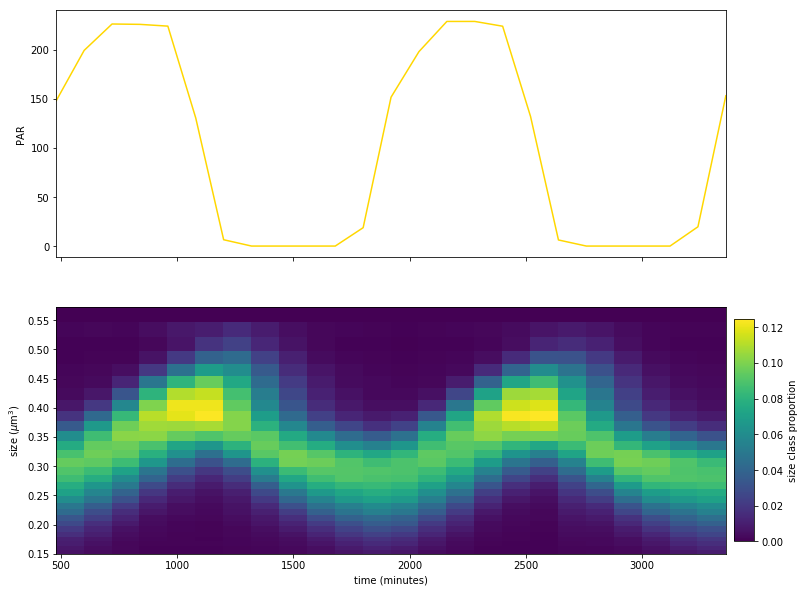

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_seaflow['time'], data_seaflow['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_seaflow['time'],v,data_seaflow['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [4]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_seaflow[k]

data['obs'] = data_seaflow['w_obs']
data['t_obs'] = data_seaflow['time']
data['E'] = data_seaflow['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_seaflow['w_obs'][:,0]

# limit the data

limit_days = 2
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]
    
# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_seaflow['time'], fp=data_seaflow['PAR'])

print(data['t_obs'])

[ 480  600  720  840  960 1080 1200 1320 1440 1560 1680 1800 1920 2040
 2160 2280 2400 2520 2640 2760]


### load various models and modify prior for some of them

In [5]:
import re

stan_files = {
    'freedelta':'stancode/matrixmodel_freedelta_normparam_trackgrowth.stan',
    'resp':'stancode/matrixmodel_freedelta_resp_normparam_trackgrowth.stan',
    'respi_gammai':'stancode/matrixmodel_freedelta_respi_gammai_normparam_trackgrowth.stan',
}
desc = {
    'freedelta':'basic model with "free" deltas',
    'resp':'model with respiration and "free" deltas',
    'respi_gammai':'model with size-dep. respiration, size-dep. growth and "free" deltas',
}

stan_codes = {}
for name in stan_files:
    with open(stan_files[name]) as f:
        stan_codes[name] = f.read()

for name in ('resp','respi_gammai'):
    name_new = name+'_enforceresp'
    code_split = stan_codes[name].split('\n')
    code_split_new = []
    for line in code_split:
        m = re.match('^( *respiration *\~)',line)
        if m:
            code_split_new.append(m.groups(0)[0]+' uniform(0.1,10.0); // enforce respiration')
        else:
            code_split_new.append(line)
    stan_codes[name_new] = '\n'.join(code_split_new)
    desc[name_new] = desc[name] + ' with enforced respiration'

In [6]:
import pystan

models = {name:pystan.StanModel(model_code=stan_codes[name], model_name=name, obfuscate_model_name=False) for name in stan_codes}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL resp NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL respi_gammai NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL resp_enforceresp NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL respi_gammai_enforceresp NOW.


In [7]:
mcmcs = {}
for name in models:
    mcmcs[name] = models[name].sampling(data=data, iter=2000)
    print('\n'.join(x for x in mcmcs[name].__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: freedelta.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            1.77    0.64   1.04   0.51    0.8   1.65   2.43    4.1      3   2.01
delta_sigma          2.1    0.95   1.46   0.36   0.91   1.78   3.02   5.48      2   2.43
delta_max[1]        0.08    0.03   0.09 2.3e-3   0.02   0.05   0.11   0.31      7   1.19
delta_max[2]        0.09    0.04    0.1 1.6e-3   0.02   0.05   0.12   0.38      8   1.17
delta_max[3]        0.11    0.05   0.13 2.4e-3   0.03   0.07   0.15   0.47      6   1.23
delta_max[4]        0.14    0.07   0.17 2.5e-3   0.03   0.08    0.2   0.63      5   1.27
delta_max[5]        0.23    0.12   0.26 3.4e-3   0.04   0.13   0.32   0.96      5    1.3
delta_max[6]        0.32    0.16   0.36 4.6e-3   0.07   0.19   0.45   1.33      5   1.29
delta_max[7]        0.47    0.22   0.48   0.

Inference for Stan model: resp.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            0.01  4.1e-4 7.6e-3 1.4e-3 5.5e-3 9.3e-3   0.01   0.03    348   1.01
delta_sigma       4.3e-3  2.3e-4 4.4e-3 3.5e-4 1.5e-3 2.9e-3 5.4e-3   0.02    354   1.01
delta_max[1]        0.01  3.9e-4 8.1e-3 7.0e-4 4.4e-3 8.4e-3   0.01   0.03    419   1.01
delta_max[2]        0.01  3.7e-4 8.0e-3 8.5e-4 4.3e-3 8.2e-3   0.01   0.03    472    1.0
delta_max[3]        0.01  3.8e-4 8.0e-3 8.6e-4 4.4e-3 8.3e-3   0.01   0.03    441   1.01
delta_max[4]        0.01  3.8e-4 8.3e-3 9.8e-4 4.5e-3 8.4e-3   0.01   0.03    471   1.01
delta_max[5]        0.01  4.0e-4 8.6e-3 7.1e-4 4.6e-3 8.8e-3   0.01   0.03    458   1.01
delta_max[6]        0.01  4.1e-4 9.1e-3 9.1e-4 4.7e-3 8.7e-3   0.01   0.04    485   1.01
delta_max[7]        0.01  4.2e-4 8.9e-3 7.4e-4 4.

Inference for Stan model: respi_gammai.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            0.01  4.2e-4 8.5e-3 2.0e-3 6.9e-3   0.01   0.02   0.03    409   1.01
delta_sigma       4.6e-3  2.9e-4 4.9e-3 2.2e-4 1.4e-3 3.1e-3 6.1e-3   0.02    286   1.01
delta_max[1]        0.01  4.1e-4 9.4e-3 1.0e-3 5.8e-3   0.01   0.02   0.04    524   1.01
delta_max[2]        0.01  4.3e-4 9.4e-3 1.2e-3 6.0e-3   0.01   0.02   0.04    487   1.01
delta_max[3]        0.01  4.2e-4 9.4e-3 9.0e-4 5.7e-3   0.01   0.02   0.04    502   1.01
delta_max[4]        0.01  4.1e-4 9.4e-3 1.1e-3 5.9e-3   0.01   0.02   0.04    518   1.01
delta_max[5]        0.01  4.3e-4 9.6e-3 1.1e-3 6.0e-3   0.01   0.02   0.04    512   1.01
delta_max[6]        0.01  4.5e-4   0.01 1.2e-3 5.7e-3   0.01   0.02   0.04    510   1.01
delta_max[7]        0.01  4.3e-4 9.8e-3 1

Inference for Stan model: resp_enforceresp.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu          9.1e-3  1.4e-3 7.5e-3 3.4e-4 3.7e-3 7.2e-3   0.01   0.03     27   1.17
delta_sigma       3.2e-3  4.3e-4 3.6e-3 1.8e-5 7.2e-4 2.0e-3 4.4e-3   0.01     69    1.1
delta_max[1]      8.6e-3  1.4e-3 7.9e-3 3.3e-4 2.8e-3 6.6e-3   0.01   0.03     33   1.13
delta_max[2]      8.6e-3  1.4e-3 7.8e-3 3.3e-4 2.8e-3 6.7e-3   0.01   0.03     30   1.14
delta_max[3]      8.7e-3  1.3e-3 8.1e-3 3.1e-4 2.8e-3 6.8e-3   0.01   0.03     37   1.12
delta_max[4]      8.8e-3  1.4e-3 8.2e-3 3.3e-4 2.9e-3 6.6e-3   0.01   0.03     37   1.13
delta_max[5]      8.9e-3  1.4e-3 8.2e-3 3.3e-4 2.9e-3 6.9e-3   0.01   0.03     35   1.12
delta_max[6]      9.1e-3  1.4e-3 8.6e-3 3.3e-4 2.9e-3 6.9e-3   0.01   0.03     36   1.13
delta_max[7]      9.2e-3  1.4e-3 8.5e

Inference for Stan model: respi_gammai_enforceresp.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            0.01  4.8e-4 8.6e-3 2.4e-3 7.0e-3   0.01   0.02   0.03    316   1.01
delta_sigma       4.8e-3  2.8e-4 4.9e-3 6.3e-5 1.4e-3 3.2e-3 6.5e-3   0.02    298   1.02
delta_max[1]        0.01  4.7e-4 9.4e-3 1.4e-3 5.9e-3   0.01   0.02   0.04    393   1.01
delta_max[2]        0.01  4.6e-4 9.4e-3 1.2e-3 5.9e-3   0.01   0.02   0.04    422   1.01
delta_max[3]        0.01  4.5e-4 9.5e-3 1.1e-3 5.7e-3   0.01   0.02   0.04    444   1.01
delta_max[4]        0.01  4.7e-4 9.5e-3 1.4e-3 5.9e-3   0.01   0.02   0.04    409   1.01
delta_max[5]        0.01  4.8e-4 9.8e-3 1.3e-3 5.9e-3   0.01   0.02   0.04    415   1.01
delta_max[6]        0.01  4.5e-4 9.8e-3 1.3e-3 6.0e-3   0.01   0.02   0.04    465   1.01
delta_max[7]        0.01  4.7

## Plot the results

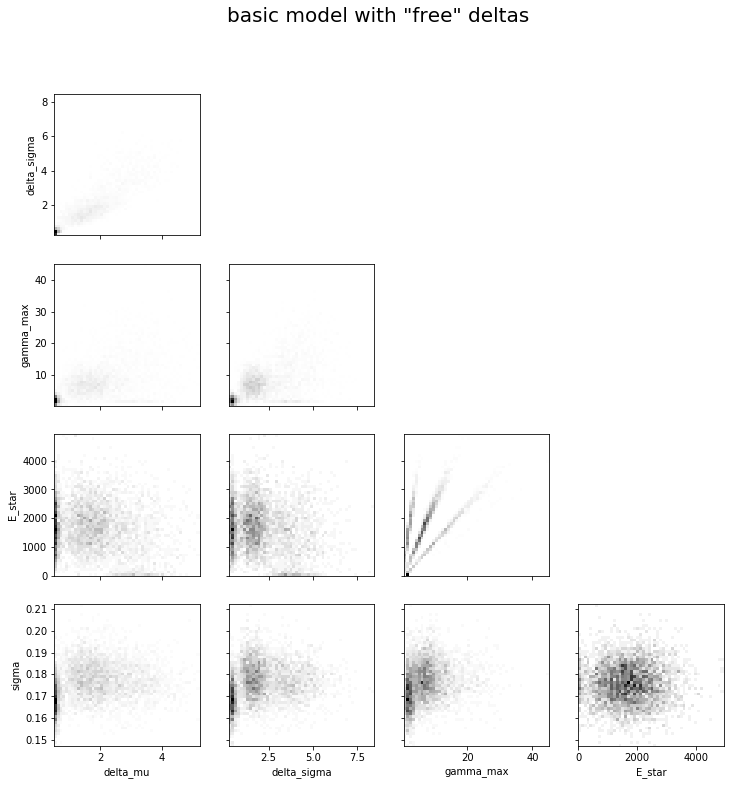

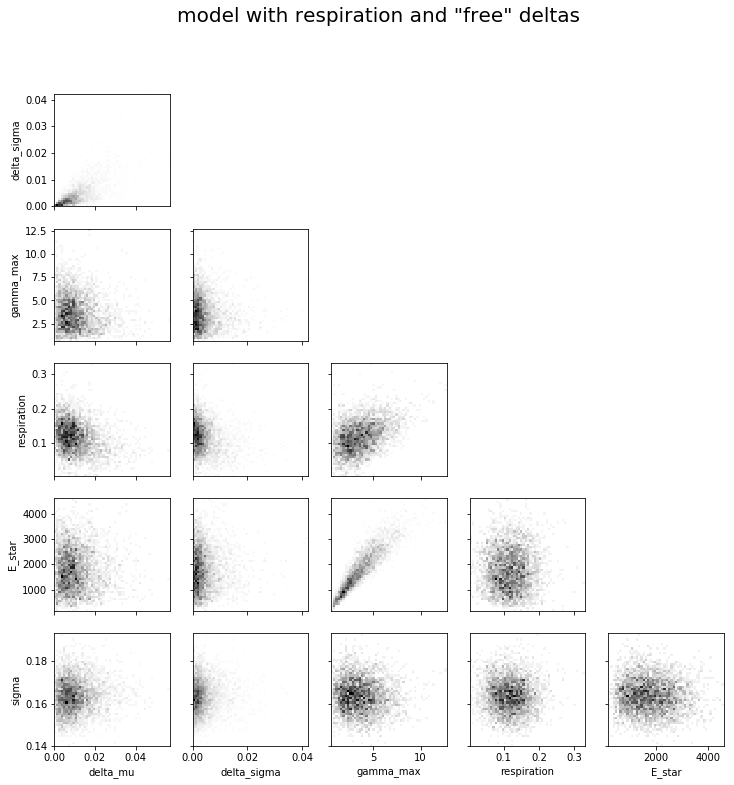

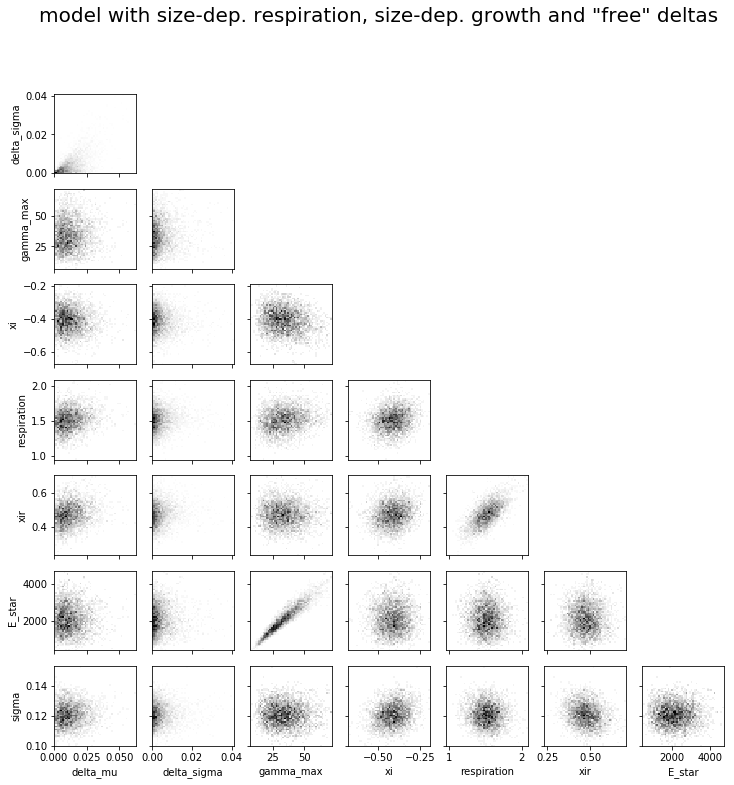

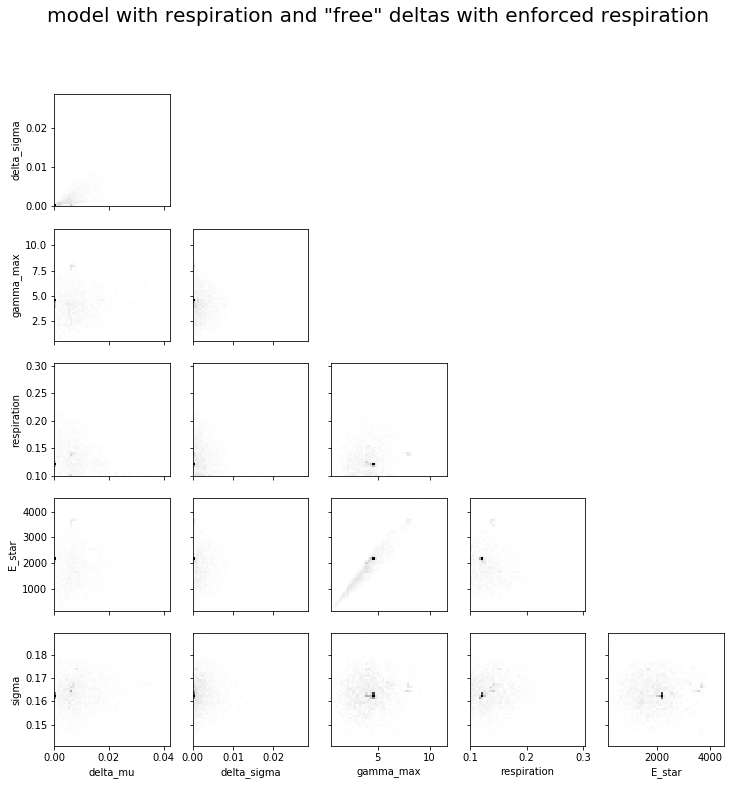

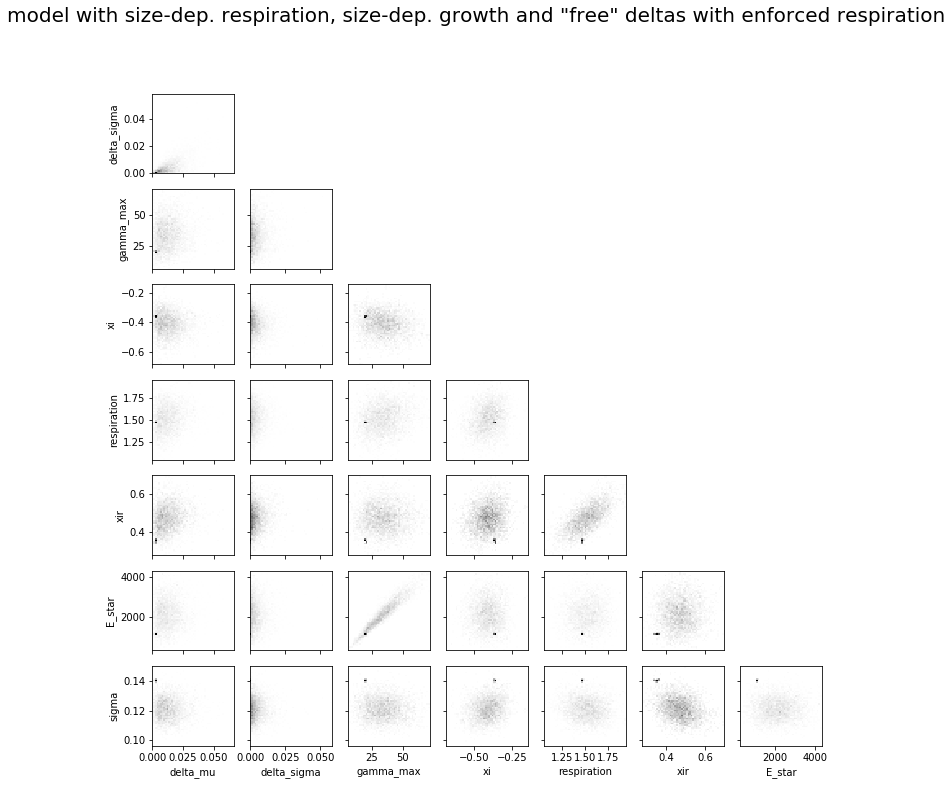

In [8]:
for name,mcmc in mcmcs.items():
    paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max')]
    num_params = len(paramnames)

    fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
    fig.suptitle(desc[name], size=20)
    for ax in axs.flat:
        ax.set_visible(False)
    for irow in range(1,num_params):
        for icol in range(irow):
            ax = axs[irow-1,icol]
            ax.set_visible(True)
            xname = paramnames[icol]
            yname = paramnames[irow]
            ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
            if icol == 0:
                ax.set_ylabel(yname)
            if irow == num_params-1:
                ax.set_xlabel(xname)

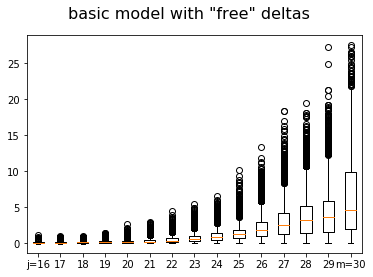

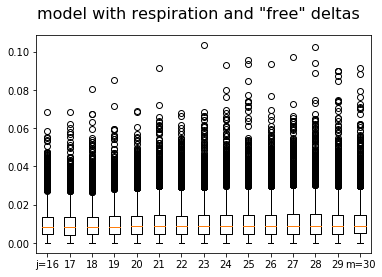

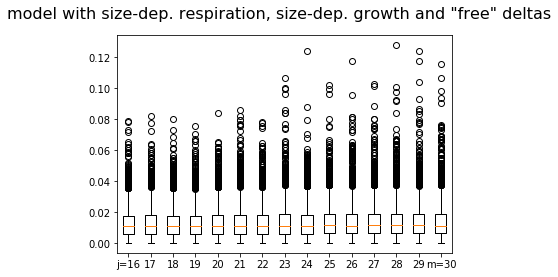

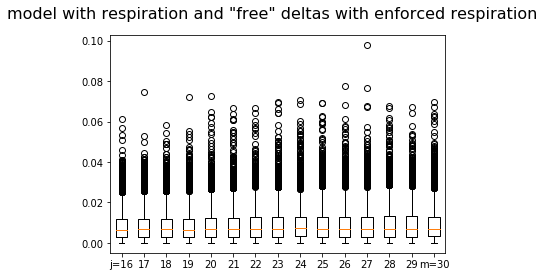

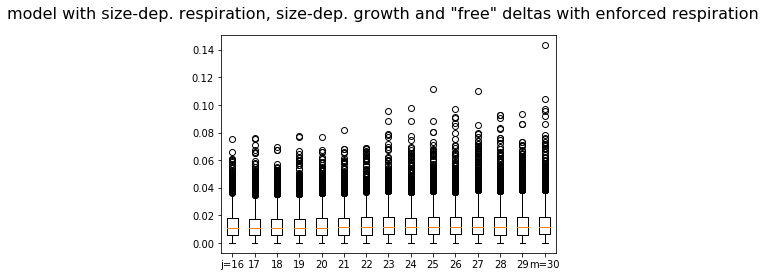

In [9]:
for name,mcmc in mcmcs.items():
    j = data_seaflow['delta_v_inv'] + 1
    m = data_seaflow['m']
    
    fig, ax = plt.subplots()
    fig.suptitle(desc[name], size=16)
    ax.boxplot(mcmc['delta_max'])
    xlabels = [str(x) for x in range(j,m+1)]
    xlabels[0] = 'j='+xlabels[0]
    xlabels[-1] = 'm='+xlabels[-1]
    ax.set_xticklabels(xlabels)
    None

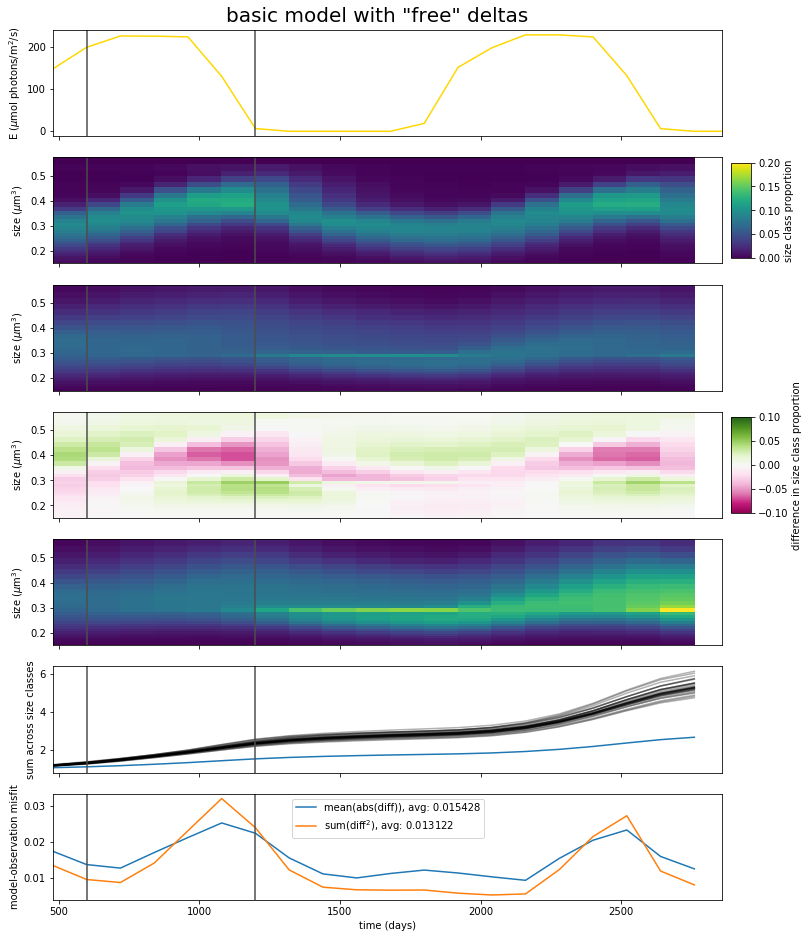

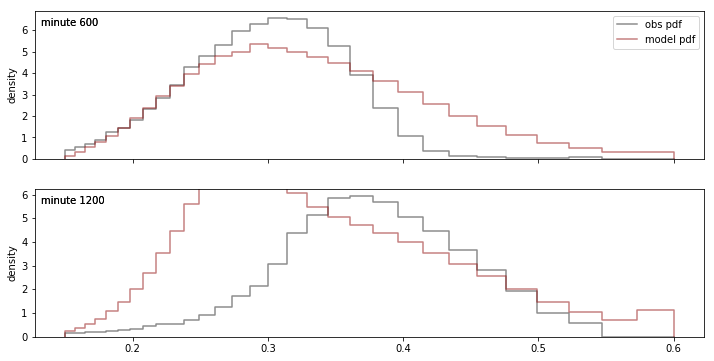

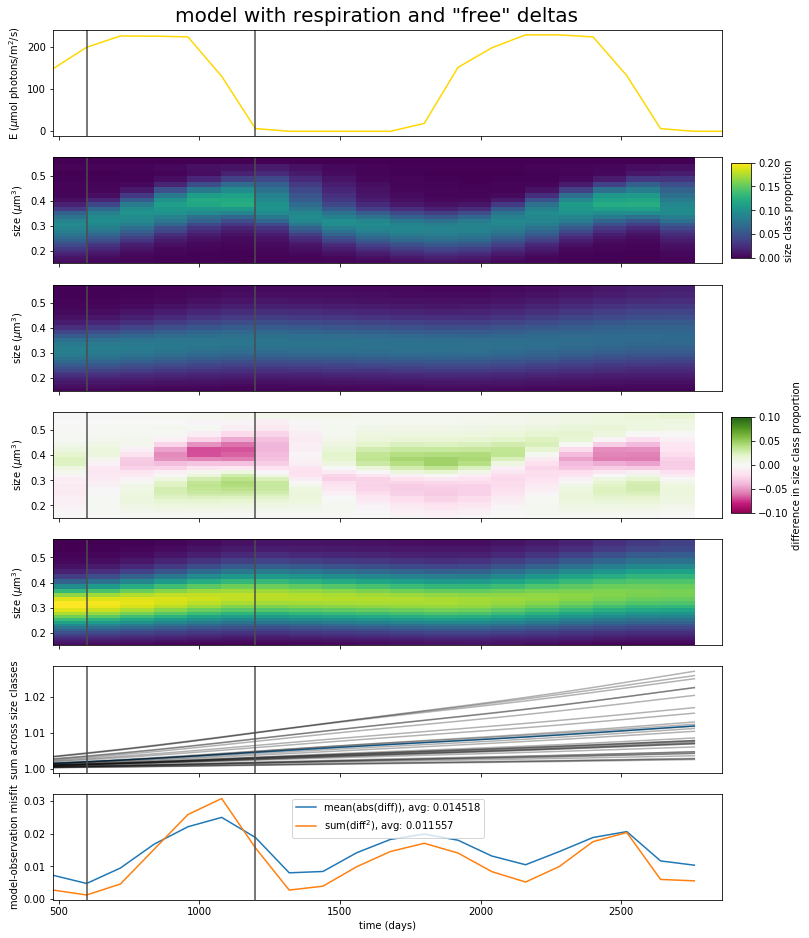

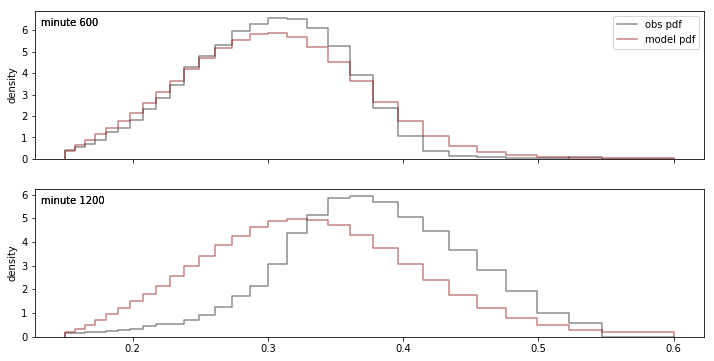

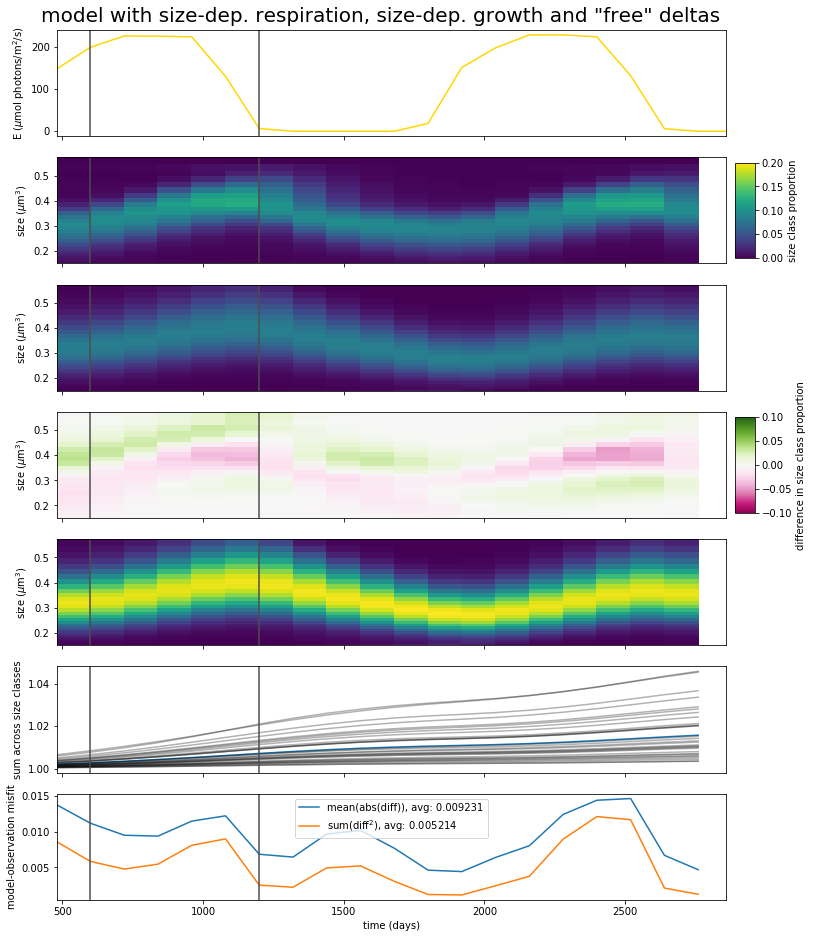

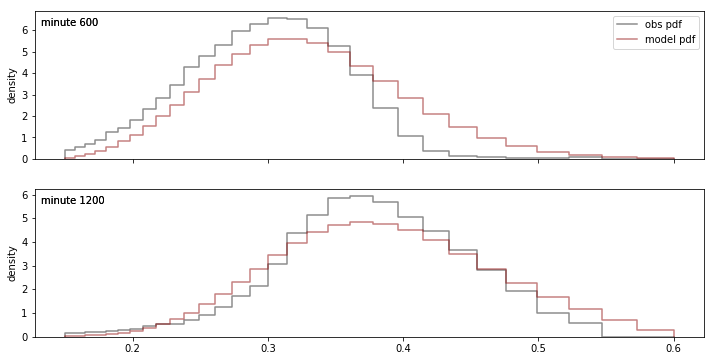

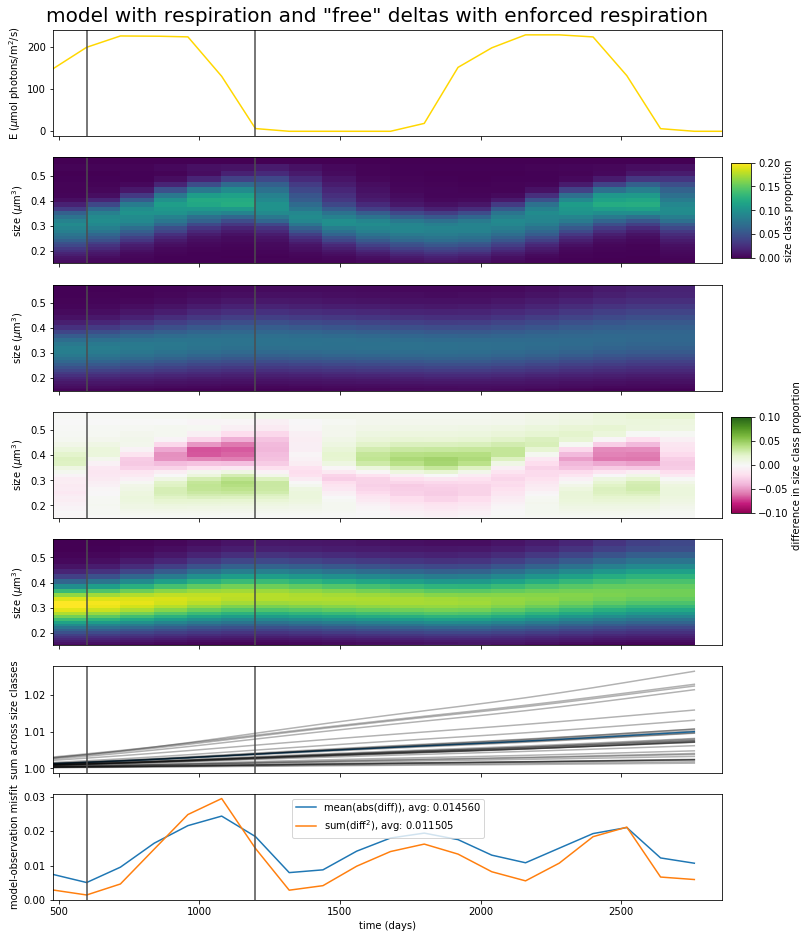

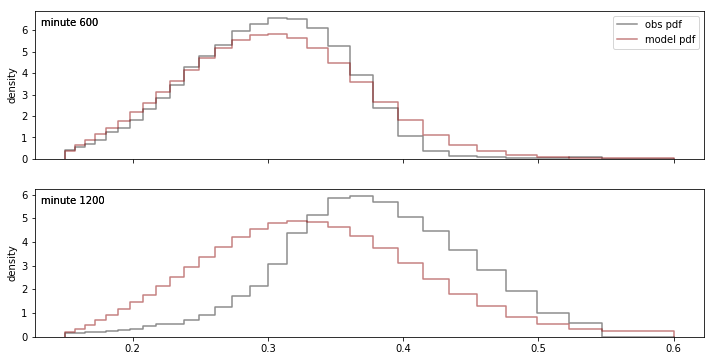

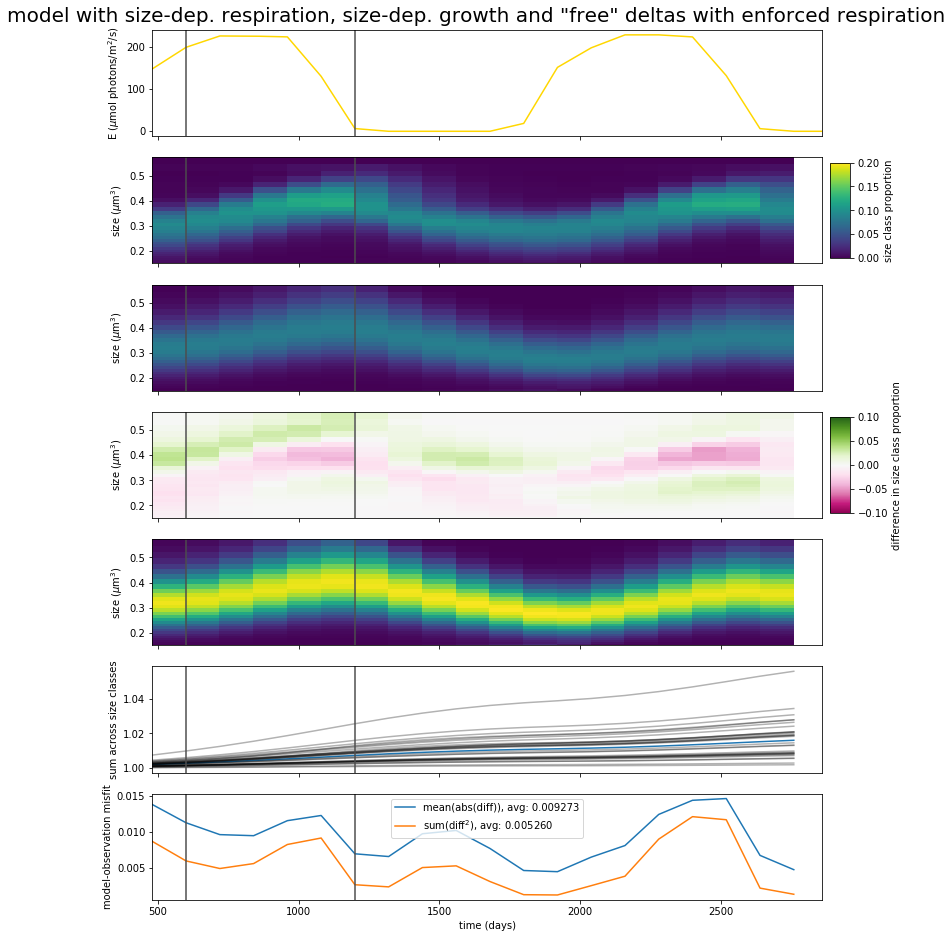

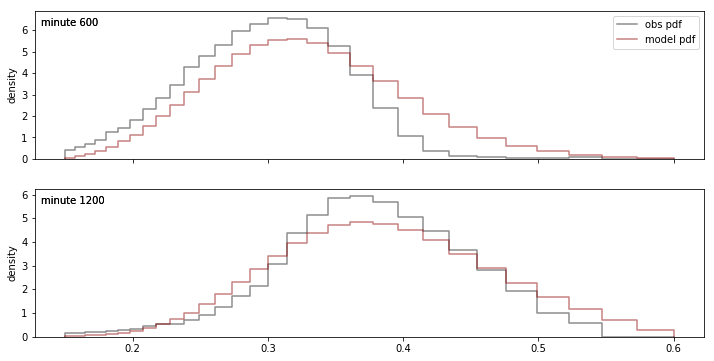

In [10]:
colors = {'model':'darkred', 'obs':'0.1'}

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
    res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
    diff = res_sum1-res['obs']

    fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
    fig.suptitle(desc[name], size=20, y=0.9)
    
    ax = axs[0]
    ax.plot(t, data['E'], color='gold')
    ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

    ax = axs[1]
    pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

    ax = axs[2]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res_sum1,norm=norm)

    ax = axs[3]
    pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
    ax.set(ylabel='size ($\mu$m$^3$)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

    ax = axs[4]
    ax.set(ylabel='size ($\mu$m$^3$)')
    pc = ax.pcolormesh(data['t_obs'],v,res['model'])

    ax = axs[5]
    ax.plot(data['t_obs'], np.sum(res['model'],axis=0))
    ax.plot(data['t_obs'], np.sum(mcmc['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
    ax.set(ylabel='sum across size classes')

    ax = axs[6]
    prop = np.mean(np.abs(diff),axis=0)
    ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
    prop = np.sum(diff**2,axis=0)
    ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
    ax.set(xlabel='time (days)', ylabel='model-observation misfit')
    ax.legend()

    for ax in axs.flat:
        for i in slice_indices:
            ax.axvline(data['t_obs'][i], color='.3')

    # plot slices

    plotdata_y = np.zeros(2*(data['m']+1))

    fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
    for i,ax in zip(slice_indices,axs.flat):
        for name in ('obs','model'):
            color = colors[name]
            cdata = res[name][:,i]
            plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
            ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
            ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
            ax.set_ylabel('density')
            ax.set_ylim(bottom=0.0)
    axs[0].legend()
    None

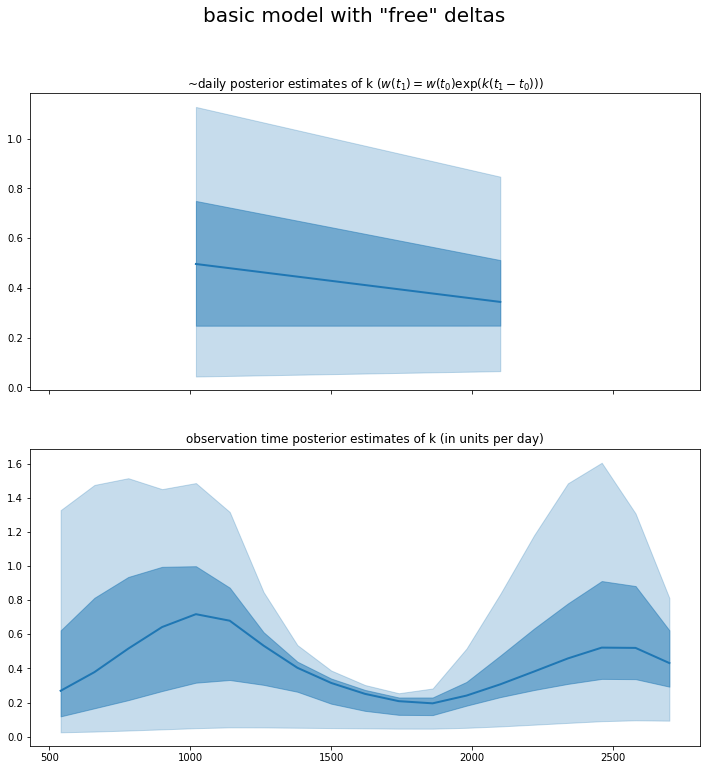

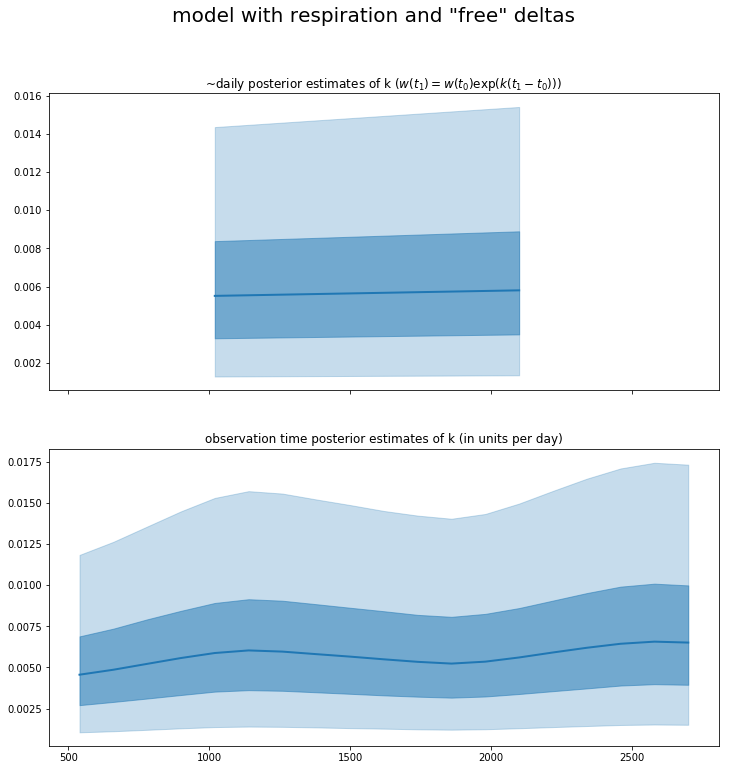

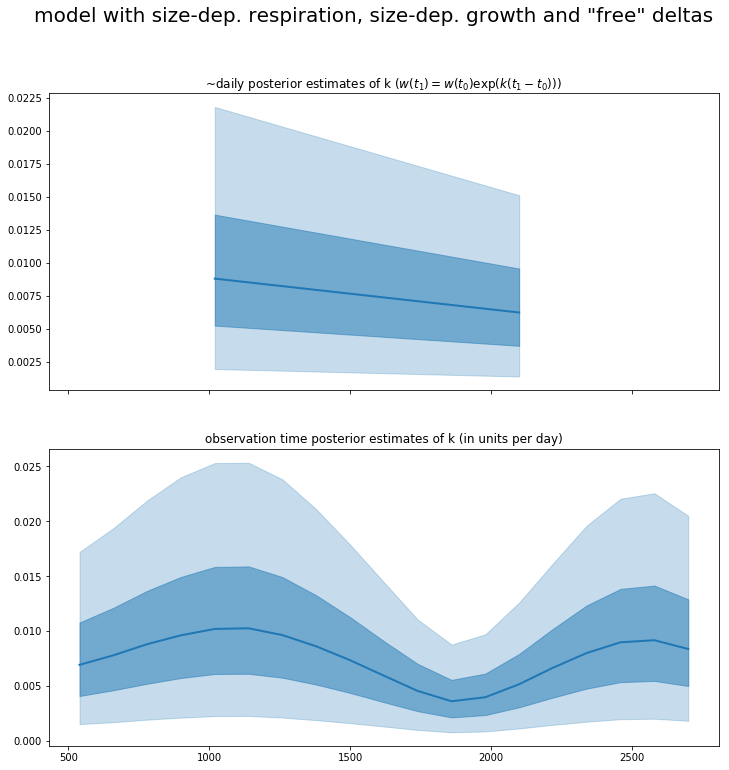

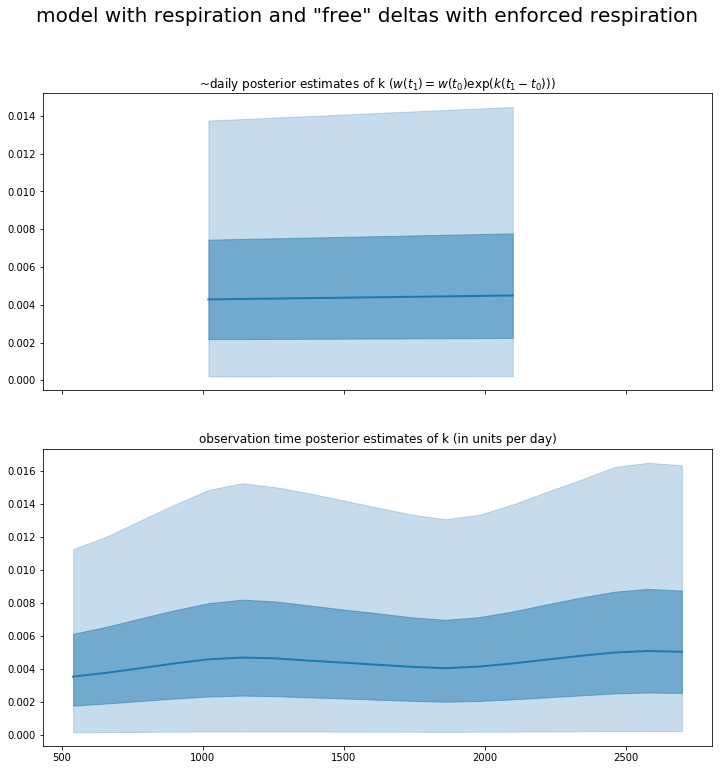

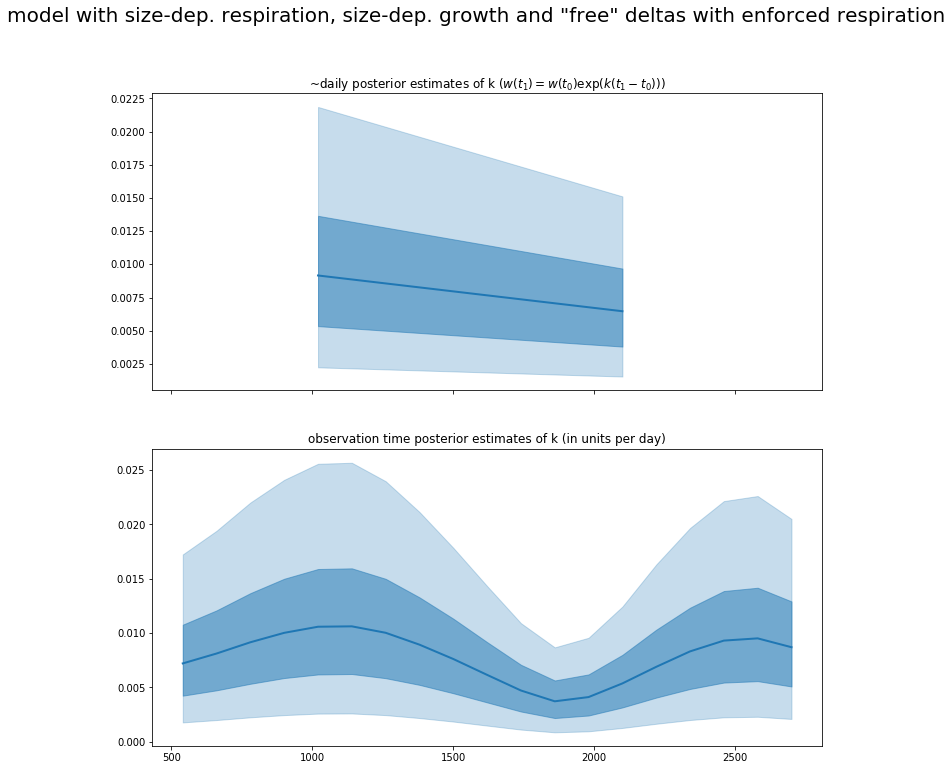

In [11]:
dt_obs = data['t_obs'][1]-data['t_obs'][0]

ndt = {'day':9, 'dt_obs':1}

for name,mcmc in mcmcs.items():
    sum_pop = np.sum(mcmc['mod_obspos'], axis=1)

    fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
    fig.suptitle(desc[name], size=20)
    for ax,key in zip(axs,ndt):
        t = data['t_obs'][::ndt[key]]
        tmp = sum_pop[:,::ndt[key]]
        tmp = tmp[:,1:] / tmp[:,:-1]
        k = np.log(tmp)/((t[1:]-t[:-1])/1440.0)

        q = np.percentile(k, q=(5,25,50,75,95), axis=0)

        t_mid = 0.5*(t[1:]+t[:-1])

        ax.fill_between(t_mid, q[0,:], q[-1,:], color='C0', alpha=0.25)
        ax.fill_between(t_mid, q[1,:], q[-2,:], color='C0', alpha=0.5)
        ax.plot(t_mid, q[2,:], color='C0', lw=2)
    axs[0].set_title('~daily posterior estimates of k ($w(t_1) = w(t_0)\exp(k (t_1-t_0))$)')
    axs[1].set_title('observation time posterior estimates of k (in units per day)')
    None